## Build a Movie Recommender System with Collaborative Filtering and Matrix Factorization

The dataset we will be using is **Kaggle MovieLens 20M dataset.**

The dataset describes ratings and free-text tagging activities from MovieLens, a movie recommendation service. It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on October 17, 2016.

Users were selected at random for inclusion. All selected users had rated at least 20 movies.

In this dataset, we are interested in the **rating.csv** and **movie.csv** files specifically,.

The **rating.csv** file contains ratings of movies by users. It has following columns:

userId, movieId, rating, timestamp.

We are interested in **userId, movieId and rating.** The range of rating is 0~5. The actual min value of ratings in the dataset is 0.5. The actual max value of ratings in the dataset is 5.0.

The **movie.csv** file contains information of movies. It has following columns:

movieId, title, genres.

In order to run the following codes, we firstly need to download the **rating.csv** and **movie.csv** files in the link provided below. After downloading the files, we need to put them in the **same directory** as this notebook. 

Link for the MovieLens 20M dataset: https://www.kaggle.com/grouplens/movielens-20m-dataset

<img src="https://i.imgur.com/AZ4qOOn.png"  width="1000" align="center"/>

In [1]:
import pandas as pd
import numpy as np
from sortedcontainers import SortedList
from tqdm import tqdm
import json
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [43]:
class Recommender_System():
    
    def __init__(self):
        
        # initialize the field variables
        self.user2movie_train={}
        self.movie2user_train={}
        self.rating_train={}
        self.user2movie_test={}
        self.movie2user_test={}
        self.rating_test={}
        self.ratings_average = None
        self.ratings_deviation = None 
        self.users_neigbors = None
        self.movies_neigbors = None
        self.reset_users = None
        self.reset_movies_reframe = None
        self.reset_movies_reduce = None
    
    
    def load_files(self,path):
        
        """
        This function loads csv files, turns it to a pandas dataframe.
        
        If other files are passed into this function, minor adjustment may be needed.
        """   
        
        df = pd.read_csv(path,header='infer')
        
        return df        
    
    def reframe(self,path):
              
        """
        This function reframes the dataframe.
        
        If other files are passed into the "load_files" function, minor adjustment may be needed here when reframing.
        
        """
        print("Reset index...")
        df = self.load_files(path).drop(columns=["timestamp"]) 
        
        # Reset userId index starting from zero
        df['userId'] = df['userId'] - 1
        
        # Reset movieId index to be continuous      
        set_of_movie_ids = sorted(set(df['movieId'].values))    
        self.reset_movies_reframe = self.reset(set_of_movie_ids)       
        df['movieId'] = df['movieId'].apply(lambda r:self.reset_movies_reframe[r])
        
        print("Done.")       
        return df
                
    def reduce(self,df,N,M):
        
        print("Reducing data...")
        users = self.counter(df['userId'].values)
        movies = self.counter(df['movieId'].values)
        top_users = [x[0] for x in sorted(users.items(),key=lambda x: x[1],reverse=True)[:N]]
        top_movies = [x[0] for x in sorted(movies.items(),key=lambda x: x[1],reverse=True)[:M]]
        df = df[df['userId'].isin(top_users) & df['movieId'].isin(top_movies)]
        
        # reset user and movie index to make it continuous
        
        set_of_user_ids = sorted(set(df['userId'].values))
        set_of_movie_ids = sorted(set(df['movieId'].values))
        self.reset_users = self.reset(set_of_user_ids)
        self.reset_movies_reduce = self.reset(set_of_movie_ids)
        df['userId'] = df['userId'].apply(lambda r: self.reset_users[r])
        df['movieId'] = df['movieId'].apply(lambda r: self.reset_movies_reduce[r])
        print("Done.")
        
        
        return df
        
            
    def mapping_training_set(self,row):
        
        """
        This function creates user2movie, movie2user, and rating maps of the training dataset by row.
        
        """
        
        i = row['userId']
        j = row['movieId']
        if i not in self.user2movie_train:
            self.user2movie_train[i] = [j]
        else:
            self.user2movie_train[i].append(j)

        if j not in self.movie2user_train:
            self.movie2user_train[j] = [i]
        else:
            self.movie2user_train[j].append(i)
            
        self.rating_train[(i,j)] = row['rating']            

        
    def mapping_test_set(self,row):
        
        """
        This function creates user2movie, movie2user, and rating maps of the test dataset by row.
        
        """
        
        i = row['userId']
        j = row['movieId']
        
        # No need to create user2movie_test and movie2user_test, though we can
        # If we want to create user2movie_test and movie2user_test, just copy the pattern in "mapping_training_set" function
        
        if i not in self.user2movie_test:
            self.user2movie_test[i] = [j]
        else:
            self.user2movie_test[i].append(j)

        if j not in self.movie2user_test:
            self.movie2user_test[j] = [i]
        else:
            self.movie2user_test[j].append(i) 
            
 
        self.rating_test[(i,j)] = row['rating']    
        
    def mapping(self,df,train_test_split):
        
        """
        This function uses pd.apply method combined with "mapping_training_set" and "mapping_test_set" function
        
        to create user2movie, movie2user, and rating maps.
        
        """
        
        N = len(set(df['userId'].values)) 
        M = len(set(df['movieId'].values)) 
        again = True
        print("Mapping data...")
        while again == True:
            # shuffle the dataframe
            df = df.sample(frac=1)
            df_len = len(df)
            df_train = df.iloc[:int(train_test_split*df_len)]
            df_test = df.iloc[int(train_test_split*df_len):]
            # pass it to variables a and b in order to suppress the results
            a = df_train.apply(self.mapping_training_set,axis=1)
            b = df_test.apply(self.mapping_test_set,axis=1)
            L1 = len(list(self.user2movie_train.keys()))
            L2 = len(list(self.user2movie_test.keys()))
            L3 = len(list(self.movie2user_train.keys()))
            L4 = len(list(self.movie2user_test.keys()))
            if L1==N and L2 ==N and L3==M and L4==M:
                # Sort maps, userId and movieId both start from 0
                self.user2movie_train = {x[0]:x[1] for x in tqdm(sorted(self.user2movie_train.items(),key=lambda x:x[0]))}
                self.user2movie_test = {x[0]:x[1] for x in tqdm(sorted(self.user2movie_test.items(),key=lambda x:x[0]))}
                self.movie2user_train = {x[0]:x[1] for x in tqdm(sorted(self.movie2user_train.items(),key=lambda x:x[0]))}
                self.movie2user_train = {x[0]:x[1] for x in tqdm(sorted(self.movie2user_train.items(),key=lambda x:x[0]))}   
                again=False
                print("Done.")
                
    def personalized_weights_UB(self,df,train_test_split,threshold,k_nearest):
        
        """
        This function is the core of collaborative filtering recommender system algorithm.
        
        It defines the personalized weights for each pair of users. This function is about user-based collaborative
        
        filtering technique.
        
        """
        
        self.mapping(df,train_test_split)
        self.ratings_average = [] # Each user's average rating on all movies he or she has rated
        self.ratings_deviation = [] # Each user's deviation on all movies he or she has rated, a list of dictionary
        # Each user's k-nearest neigbors' weights. For each user, it is a SortedList object of k-nearest neighbors, 
        # in which the information of each neighbor of the user is stored as a tuple (weights,userId)
        self.users_neigbors = [] 
        N = len(set(df['userId'].values))
        print("Generating personalized weights...")
        for i in tqdm(range(N)):
            movies_for_i = self.user2movie_train[i]
            # set is used for intersection between user i and user j later
            movies_for_i_set = set(movies_for_i)
            # a dictionary where key is the movieId, value is the rating that user i gives to this movie
            ratings_for_i={movie:self.rating_train[(i,movie)] for movie in movies_for_i_set}
            average_for_i = np.mean(list(ratings_for_i.values()))
            # a dictionary of each movie corresponding to a deviation of rating
            deviation_for_i = {movie:(rating-average_for_i) for movie,rating in ratings_for_i.items()}
            deviation_i_values = np.array(list(deviation_for_i.values()))
            # standard deviation for pearson coefficient
            sigma_i = np.sqrt(deviation_i_values.dot(deviation_i_values))
            self.ratings_average.append(average_for_i)
            self.ratings_deviation.append(deviation_for_i)
            # Establish a SortedList object (similar to java)
            sorted_list = SortedList()
            # Compute the weights between two users
            for j in range(N):
                # No need to compute weights for the user itself since we don't use the information of user who needs 
                #to be recommended to recommend the user itself
                if i != j:
                    movies_for_j = self.user2movie_train[j]
                    movies_for_j_set = set(movies_for_j)
                    movie_intersect = (movies_for_i_set & movies_for_j_set)
                    # Abandon if two users have too few common items that they share because in that case not much
                    # useful information will be provided. It could speed up the algorithm.
                    if len(movie_intersect) > threshold:
                        ratings_for_j={movie:self.rating_train[(j,movie)] for movie in movies_for_j_set}
                        average_for_j = np.mean(list(ratings_for_j.values()))
                        # a dictionary of each movie corresponding to a deviation of rating
                        deviation_for_j = {movie:(rating-average_for_j) for movie,rating in ratings_for_j.items()}
                        deviation_j_values = np.array(list(deviation_for_j.values()))
                        sigma_j = np.sqrt(deviation_j_values.dot(deviation_j_values))
                        # Compute the weight between two users with pearson cofficient
                        numerator = np.sum(deviation_for_i[m]*deviation_for_j[m] for m in movie_intersect)
                        denominator = sigma_i*sigma_j
                        w_i_j = numerator/denominator

                        # Note: Since SortedList sorts in ascending order, in order to get highest weights 
                        #(k-nearest) we want, we add a minus sign before the weight. 
                        # Later when doing recommendation, the minus sign should be dropped. We could also try 
                        # the absolute value.
                        sorted_list.add((-w_i_j,j)) # j is user
                        
                        # Drop the rest of weights. Always keep only k-length neighbors (or less), to save space.
                        if len(sorted_list) > k_nearest:
                            del sorted_list[-1]

            self.users_neigbors.append(sorted_list)
        
        print("Done.")
        
        
        
        
    def personalized_weights_IB(self,df,train_test_split,threshold,k_nearest):
        
        """
        This function is the core of collaborative filtering recommender system algorithm.
        
        It defines the personalized weight for each pair of movies. This function is about item-based collaborative
        
        filtering technique.
        
        """
        
        self.mapping(df,train_test_split)
        self.ratings_average = [] # Each movie's average rating by all users
        self.ratings_deviation = [] # Each movie's deviation
        
        # Each movie's k-nearest neigbors' weights. 
        # Each element in the list is a SortedList object of k-nearest neighbors.
        self.movies_neigbors = [] 
        M = len(set(df['movieId'].values))
        print("Generating personalized weights...")
        for i in tqdm(range(M)):
            # index i under this loop represents movie i
            users_for_i = self.movie2user_train[i]
            users_for_i_set = set(users_for_i)
            # a dictionary where key is the userId, value is the rating
            ratings_for_i={user:self.rating_train[(user,i)] for user in users_for_i_set}
            average_for_i = np.mean(list(ratings_for_i.values()))
            # a dictionary of each user corresponding to a deviation of rating
            deviation_for_i = {user:(rating-average_for_i) for user,rating in ratings_for_i.items()}
            deviation_i_values = np.array(list(deviation_for_i.values()))
            # standard deviation for pearson coefficient
            sigma_i = np.sqrt(deviation_i_values.dot(deviation_i_values))
            self.ratings_average.append(average_for_i)
            self.ratings_deviation.append(deviation_for_i)
            # Establish a SortedList object (similar to java)
            sorted_list = SortedList()
            # Compute the weights between two movies
            for j in range(M):
                
                if i != j:
                    users_for_j = self.movie2user_train[j]
                    users_for_j_set = set(users_for_j)
                    user_intersect = (users_for_i_set & users_for_j_set)
                    # Abandon the case if two movies have too few common users.
                    if len(user_intersect) > threshold:
                        ratings_for_j={user:self.rating_train[(user,j)] for user in users_for_j_set}
                        average_for_j = np.mean(list(ratings_for_j.values()))
                        # a dictionary of each movie corresponding to a deviation of rating
                        deviation_for_j = {user:(rating-average_for_j) for user,rating in ratings_for_j.items()}
                        deviation_j_values = np.array(list(deviation_for_j.values()))
                        sigma_j = np.sqrt(deviation_j_values.dot(deviation_j_values))
                        # Compute the weight between two movies with pearson cofficient
                        numerator = np.sum(deviation_for_i[u]*deviation_for_j[u] for u in user_intersect)
                        denominator = sigma_i*sigma_j
                        w_i_j = numerator/denominator

                        # Note: Since SortedList sorts in ascending order, in order to get highest weights 
                        #(k-nearest) we want, we add a minus sign before the weight. 
                        # Later when doing recommendation, the minus sign should be dropped. We could also try 
                        # the absolute value.
                        sorted_list.add((-w_i_j,j)) # j is movie
                        
                        # Drop the rest of weights. Always keep only k-length neighbors (or less), to save space.
                        if len(sorted_list) > k_nearest:
                            del sorted_list[-1]

            self.movies_neigbors.append(sorted_list)
        
        print("Done.")            
            
    def recommend_UB(self,user_index,movie_index):
        
        """
        This function receives a userId and movieId, then predicts a rating that the user would give to the movie
        
        based on user-based recommender engine.
        
        
        """
        
        numerator = 0
        denominator = 0
        for weight, user_j in self.users_neigbors[user_index]:
            # If user_j happens not to rate the movie_j that user_i rates, then go to the Exception, which directly passes
            # We could also "find out " if user_j has rated the movie_j, but that would cost the time of finding items in
            # dictionary, which is not efficient. Therefore, we use try except statement.
            
            try:
                # add a second minus sign to weight to make it positive again
                numerator+=(-weight)*(self.ratings_deviation[user_j][movie_index])
                denominator+= abs(weight)

            except:

                pass
        # There might be an extreme case that this user's all neighbor users have not rated the movie that is supposed to
        # be recommended to this user. In this case, the recommendation of this movie would have to be the average of this  
        # user's rating.
        if denominator == 0:
            prediction = self.ratings_average[user_index]
        
        else:
            prediction = (numerator/denominator)+ self.ratings_average[user_index]

        # ADD boundary (0.5-5) here

        return prediction
    
    def recommend_IB(self,user_index,movie_index):
        
        """
        This function receives a userId and movieId, then predicts a rating that the user would give to the movie
        
        based on item-based recommender engine.
        
        
        """
        
        numerator = 0
        denominator = 0
        
        # If the neighboring movie happens not to be rated by the user i, then go to the Exception.
        for weight, movie in self.movies_neigbors[movie_index]:

            
            try:
                # add a second minus sign to weight to make it positive again
                numerator+=(-weight)*(self.ratings_deviation[movie][user_index])
                denominator+= abs(weight)

            except:

                pass
        # There might be an extreme case that this movie's all neighboring movies are not seen by
        # the user i, then the average rating of this movie will be the rating given to the user i.
        if denominator == 0:
            prediction = self.ratings_average[movie_index]
        
        else:
            prediction = (numerator/denominator)+ self.ratings_average[movie_index]

        # ADD boundary (0.5-5) here

        return prediction
  

    def MF_train(self,df,N,M,K,epochs,lamda,train_test_split):
        
        """
        This function is the core of Matrix Factorization recommender system algorithm.
        
        It uses Alternating Least Square method (ALS) to train the recommender system. 
        
        """        
        
        self.mapping(df,train_test_split)
        rating_train = self.rating_train
        user2movie = self.user2movie_train
        movie2user = self.movie2user_train
        W = np.random.randn(N, K)
        b = np.zeros(N)
        U = np.random.randn(M, K)
        c = np.zeros(M)
        mu = np.mean(list(rating_train.values()))
        costs = []
        for epoch in tqdm(range(epochs)):
            cost = 0
            for (i,j),r in rating_train.items():
                i = int(i)
                j = int(j)
                element = W[i].dot(U[j]) + b[i] + c[j] + mu - r
                cost+=element*element
            cost=np.sqrt(cost/len(rating_train))
            costs.append(cost)

            for i in range(N):
                matrix = np.eye(K) * lamda
                vector = np.zeros(K)
                # We can't directly use b[i] here because we need updated value b[i] for other calculation below.
                b_i = 0
                for j in user2movie[i]:
                    j = int(j)
                    r = rating_train[(i,j)]
                    matrix += np.outer(U[j], U[j])
                    vector += (r - b[i] - c[j] - mu)*U[j]
                    b_i += (r - W[i].dot(U[j]) - c[j] - mu)

                W[i] = np.linalg.solve(matrix, vector)
                b[i] = b_i / (len(user2movie[i]) + lamda)

            for j in range(M):

                matrix = np.eye(K) * lamda
                vector = np.zeros(K)

                c_j = 0
                for i in movie2user[j]:
                    i = int(i)
                    r = rating_train[(i,j)]
                    matrix += np.outer(W[i], W[i])
                    vector += (r - b[i] - c[j] - mu)*W[i]
                    c_j += (r - W[i].dot(U[j]) - b[i] - mu)

              # set the updates
                U[j] = np.linalg.solve(matrix, vector)
                c[j] = c_j / (len(movie2user[j]) + lamda)

        return W, U, b, c, mu, costs
    
    def root_mean_square_error(self,predictions,labels):
        
        """
        This function receives the predicted ratings and the true ratings,
        
        and then computes the root mean square error of the prediction.
        
        """
        
        predictions = np.array(predictions)
        labels = np.array(labels)        
        rmse = np.sqrt(np.mean((predictions - labels)**2))
        
        return rmse
        
        
    def reset(self,obj):
        
        """
        helper function: Reset index of dataframe.
        
        """
        
        reset_index = {}
        count = 0
        for i in obj:
            reset_index[i] = count
            count+=1
        
        return reset_index
  
                
    def counter(self,obj):
        
        """
        helper function: Count the object of interest.
        
        """
        
        counter = {}
        
        for item in obj:
            
            if item not in counter:
                
                counter[item] = 0
            
            counter[item]+=1
        
        return counter       
        
        
    def load_weights(self,file):
        
        with open(file,'r') as f:
            
            k_nearest_weights = json.load(f)
        
        return k_nearest_weights
    
    def save_weights(self,weights,file):
        
        with open(file,'w') as f:
            
            json.dump(weights,file)
            
            
        



### User-based recommender system

#### Instantiate the recommender system class

In [3]:
recommender_system_UB = Recommender_System()

#### Pass rating.csv file into a pandas dataframe and reset index

In [4]:
df_reframed_UB = recommender_system_UB.reframe("./rating.csv")

Reset index...
Done.


#### Reduce data to top 2000 users and 200 movies for the purpose of illustration

 We choose top 2000 users who have rated the most movies, and top 200 movies which have been rated the most.

In [5]:
df_reduced_UB = recommender_system_UB.reduce(df_reframed_UB,N=2000,M=200)

Reducing data...
Done.


#### Train recommender system ( compute personalized weights )

In order to do recommendation, the personalized weights are computed. First the dataset is split into training and test set with a ratio of 4:1. Then, a threshold = 5 is set for the least
number of common movies that two users have rated. If the number of movies that two users both have rated is less than 5, then there is no need to compute the weights between these two users share too little information. If two
users share too little information, it's not accurate enough to predict one user's behavior based on another.

A k-nearest neighbor value = 25 is also set for users that are most in common. When doing the prediction on one user, we would like to use the top 25 neighboring users who are the most similar to this user. We could also use all the other users to do prediction, but by setting an adequate k-nearest neighbor value, we can speed up the algorithm as well as reserve the accuracy of prediction. k_nearest=25 is enough to do the recommendation.

In [6]:
recommender_system_UB.personalized_weights_UB(df_reduced_UB,train_test_split=0.8,threshold=5,k_nearest=25)

Mapping data...


  0%|          | 0/2000 [00:00<?, ?it/s]

Done.
Generating personalized weights...


100%|██████████| 2000/2000 [20:15<00:00,  1.85it/s]

Done.


#### Test  recommender system ( compute the root mean square error )

There isn't a fix method for evaluating the collaborative filtering recommender system. In this project, we would like to evaluate the model by computing the root mean square error (RMSE) between the predicted rating and the true rating on the test dataset. 
The RMSE is around 0.77, which is a pretty good result for the collaborative filtering recommender system. The RMSE benchmark for recommender system is around 0.9.

In [7]:
rating_test = recommender_system_UB.rating_test
predictions = []
labels = []
for (user,movie),rating in rating_test.items():    
    prediction = recommender_system_UB.recommend_UB(int(user),int(movie))
    predictions.append(prediction)
    labels.append(rating)

rmse = recommender_system_UB.root_mean_square_error(predictions,labels)
rmse

0.6842261671613121

#### Visualize the prediction

We choose userId = 20 as above and visualize all the movies this user has rated vs the predicted ratings.

In [8]:
# Firstly, we should recover the true userId and movieId
reset_index_users = {v:k for k,v in recommender_system_UB.reset_users.items()}
reset_index_movies_reframe = {v:k for k,v in recommender_system_UB.reset_movies_reframe.items()}
reset_index_movies_reduce = {v:k for k,v in recommender_system_UB.reset_movies_reduce.items()}

In [9]:
movie_rating = [(user,movie,rating) for (user,movie),rating in recommender_system_UB.rating_train.items() if user==20] + \
               [(user,movie,rating) for (user,movie),rating in recommender_system_UB.rating_test.items() if user==20]

movies = []
true_ratings = []
predicted_ratings = []

for info in movie_rating:    
    prediction = recommender_system_UB.recommend_UB(20,int(info[1]))
    predicted_ratings.append(prediction)
    true_ratings.append(info[2])
    movies.append(reset_index_movies_reframe[reset_index_movies_reduce[info[1]]])
    
rating_df = pd.DataFrame({'movieId':movies,'trueRating':true_ratings,'predictRating':predicted_ratings})
# recover the true userId for this user
true_user_id = reset_index_users[20] + 1  



In [10]:
true_user_id

1244

In [11]:
movie_df = recommender_system_UB.load_files('./movie.csv')
movie_df.merge(rating_df,on='movieId')

,movieId,title,genres,trueRating,predictRating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,4.054965
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.5,3.107806
2,6,Heat (1995),Action|Crime|Thriller,4.0,4.091971
3,10,GoldenEye (1995),Action|Adventure|Thriller,4.0,3.749369
4,19,Ace Ventura: When Nature Calls (1995),Comedy,4.0,2.926458
5,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,4.0,4.200494
6,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,4.0,4.200494
7,34,Babe (1995),Children|Drama,3.0,2.708395
8,39,Clueless (1995),Comedy|Romance,3.5,3.097002
9,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,4.5,4.492581


### Item-based recommender system

We proceed in the same way as what we did for user-based recommender system

In [12]:
recommender_system_IB = Recommender_System()

#### Pass rating.csv file into a pandas dataframe and reset index

In [13]:
df_reframed_IB = recommender_system_IB.reframe("./rating.csv")

Reset index...
Done.


#### Reduce data to top 2000 users and 200 movies for the purpose of illustration

In [14]:
df_reduced_IB = recommender_system_IB.reduce(df_reframed_IB,N=2000,M=200)

Reducing data...
Done.


#### Train the recommender system (compute personalized weights)

In [15]:
recommender_system_IB.personalized_weights_IB(df_reduced_IB,train_test_split=0.8,threshold=5,k_nearest=25)

Mapping data...


  0%|          | 0/200 [00:00<?, ?it/s]

Done.
Generating personalized weights...


100%|██████████| 200/200 [01:12<00:00,  2.82it/s]

Done.


#### Test the recommender system ( compute the root mean square error )

In [16]:
rating_test = recommender_system_IB.rating_test
predictions = []
labels = []
for (user,movie),rating in rating_test.items():    
    prediction = recommender_system_IB.recommend_IB(int(user),int(movie))
    predictions.append(prediction)
    labels.append(rating)

rmse = recommender_system_IB.root_mean_square_error(predictions,labels)
rmse

0.7383466233860998

#### Visualize the prediction

We choose userId = 20 and visualize all the movies this user has rated vs the predicted ratings.

In [17]:
# Firstly, we should recover the true userId and movieId
reset_index_users = {v:k for k,v in recommender_system_IB.reset_users.items()}
reset_index_movies_reframe = {v:k for k,v in recommender_system_IB.reset_movies_reframe.items()}
reset_index_movies_reduce = {v:k for k,v in recommender_system_IB.reset_movies_reduce.items()}

In [18]:
movie_rating = [(user,movie,rating) for (user,movie),rating in recommender_system_IB.rating_train.items() if user==20] + \
               [(user,movie,rating) for (user,movie),rating in recommender_system_IB.rating_test.items() if user==20]

movies = []
true_ratings = []
predicted_ratings = []

for info in movie_rating:    
    prediction = recommender_system_IB.recommend_IB(20,int(info[1]))
    predicted_ratings.append(prediction)
    true_ratings.append(info[2])
    movies.append(reset_index_movies_reframe[reset_index_movies_reduce[info[1]]])
    
rating_df = pd.DataFrame({'movieId':movies,'trueRating':true_ratings,'predictRating':predicted_ratings})
# recover the true userId for this user
true_user_id = reset_index_users[20] + 1  

In [19]:
true_user_id

1244

In [20]:
movie_df.merge(rating_df,on='movieId')

,movieId,title,genres,trueRating,predictRating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,4.146059
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.5,3.544677
2,6,Heat (1995),Action|Crime|Thriller,4.0,4.101951
3,10,GoldenEye (1995),Action|Adventure|Thriller,4.0,3.784696
4,19,Ace Ventura: When Nature Calls (1995),Comedy,4.0,3.084158
5,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,4.0,3.889133
6,34,Babe (1995),Children|Drama,3.0,3.557101
7,39,Clueless (1995),Comedy|Romance,3.5,3.403703
8,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,4.5,4.292604
9,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.0,4.396936


### Compare user-based and item-based recommender systems

Item-based recommender system runs much faster than user-based recommender system.

For computing weights, user-based recommender system needs a time complexity of $O(N^2*M)$, whereas item-based recommender system needs a time complexity of $O(M^2*N)$. $M$ represents number of movies, $N$ represents number of users. Generally $N$ is much larger than $M$.


In practical, item-based recommender system is generally more accurate than user-based recommender system for following reasons:
    
(1) Generally, item-based recommender system computes the weight between two movie vectors. The dimension of a movie vector is the number of all users that have rated this movie. On the contrary, user-based recommender system computed the weight between two user vectors. The dimension of a user vector is the number of all movies that this user has rated. Therefore, item-based recommender system generally yields a better result.

(2) Due to the fact that there are much more users than movies in the dataset, the number of the pair of movies which both have been rated by 5(threshold value) or more users is higher than the number of the pair of users that both rated 5 or more movies. Therefore, item-based recommender system has more data to compute weights and accordingly yields a better result.






### Recommender system with Matrix Factorization technique

We proceed in the same way as above.

In [44]:
recommender_system_MF = Recommender_System()

#### Pass rating.csv file into a pandas dataframe and reset index

In [45]:
df_reframed_MF = recommender_system_IB.reframe("./rating.csv")

Reset index...
Done.


#### Reduce data to top 2000 users and 200 movies for the purpose of illustration

In [46]:
df_reduced_MF = recommender_system_MF.reduce(df_reframed_MF,N=2000,M=200)

Reducing data...
Done.


#### Train recommender system with Matrix Factorization

In [47]:
W, U, b, c, mu, costs = recommender_system_MF.MF_train(df=df_reduced_MF,N=2000,M=200,K=10,epochs=25,lamda=20,train_test_split=0.8)

Mapping data...


  0%|          | 0/25 [00:00<?, ?it/s]

Done.


100%|██████████| 25/25 [03:00<00:00,  7.20s/it]


Plot cost values for training dataset in each training epoch

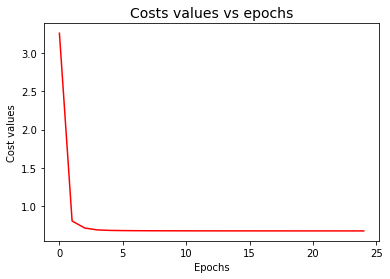

In [48]:
plt.plot(costs,'r')
plt.xlabel("Epochs")
plt.ylabel("Cost values")
plt.title("Costs values vs epochs",fontsize=14)
plt.show()

#### Test recommender system ( compute the root mean square error )

In [49]:
user2movie = recommender_system_MF.user2movie_train
movie2user = recommender_system_MF.movie2user_train
rating_train = recommender_system_MF.rating_train
rating_test = recommender_system_MF.rating_test

In [50]:
predictions = []
labels = []
for (user,movie),rating in rating_test.items():
    user = int(user)
    movie = int(movie)
    prediction = W[user].dot(U[movie]) + b[user] + c[movie] + mu
    predictions.append(prediction)
    labels.append(rating)

rmse = recommender_system_MF.root_mean_square_error(predictions,labels)
rmse

0.7319901510041341

#### Visualize the prediction

We choose userId = 20 as above and visualize all the movies this user has rated vs the predicted ratings

In [52]:
movie_rating = [(user,movie,rating) for (user,movie),rating in recommender_system_UB.rating_train.items() if user==20] + \
               [(user,movie,rating) for (user,movie),rating in recommender_system_UB.rating_test.items() if user==20]

movies = []
true_ratings = []
predicted_ratings = []

for info in movie_rating: 
    movie = int(info[1])
    prediction = W[20].dot(U[movie]) + b[20] + c[movie] + mu
    predicted_ratings.append(prediction)
    true_ratings.append(info[2])
    movies.append(reset_index_movies_reframe[reset_index_movies_reduce[info[1]]])
    
rating_df = pd.DataFrame({'movieId':movies,'trueRating':true_ratings,'predictRating':predicted_ratings})
# recover the true userId for this user
true_user_id = reset_index_users[20] + 1  

In [55]:
true_user_id

1244

In [56]:
movie_df.merge(rating_df,on='movieId')

,movieId,title,genres,trueRating,predictRating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,3.980237
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.5,3.386106
2,6,Heat (1995),Action|Crime|Thriller,4.0,3.914273
3,10,GoldenEye (1995),Action|Adventure|Thriller,4.0,3.648968
4,19,Ace Ventura: When Nature Calls (1995),Comedy,4.0,3.167972
5,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,4.0,3.945429
6,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,4.0,3.945429
7,34,Babe (1995),Children|Drama,3.0,3.462056
8,39,Clueless (1995),Comedy|Romance,3.5,3.380803
9,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,4.5,4.171517
